## 1. Model Yükleme

In [6]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Kaydedilmiş modeli yükle
model_path = './models/wear_gradientboosting_tuned_model.joblib'
loaded_data = joblib.load(model_path)
model = loaded_data['model']
feature_cols = loaded_data['features']

print('Model başarıyla yüklendi!')
print('Gerekli özellikler:', feature_cols)
print('Model tipi:', type(model).__name__)

Model başarıyla yüklendi!
Gerekli özellikler: ['Kesme Gücü', 'İlerleme Hızı', 'RPM']
Model tipi: GradientBoostingRegressor


## 2. Test Verisi ile Değerlendirme

In [7]:
# Orijinal veriyi yükle ve test setini oluştur
data_path = '/Users/onurcan/Documents/GDG_HATAY/Dataset.xlsx'
df = pd.read_excel(data_path)
df_clean = df.dropna()

from sklearn.model_selection import train_test_split
X = df_clean[feature_cols]
y = df_clean['AşınmaOranı']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)

# Metrikleri hesapla
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print('Test Seti Performansı')
print('='*50)
print(f'MAE:  {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R²:   {r2:.3f}')
print(f'Test örnekleri: {len(y_test)}')

Test Seti Performansı
MAE:  0.913
RMSE: 1.216
R²:   0.715
Test örnekleri: 368


## 3. Tahmin vs Gerçek Görselleştirme

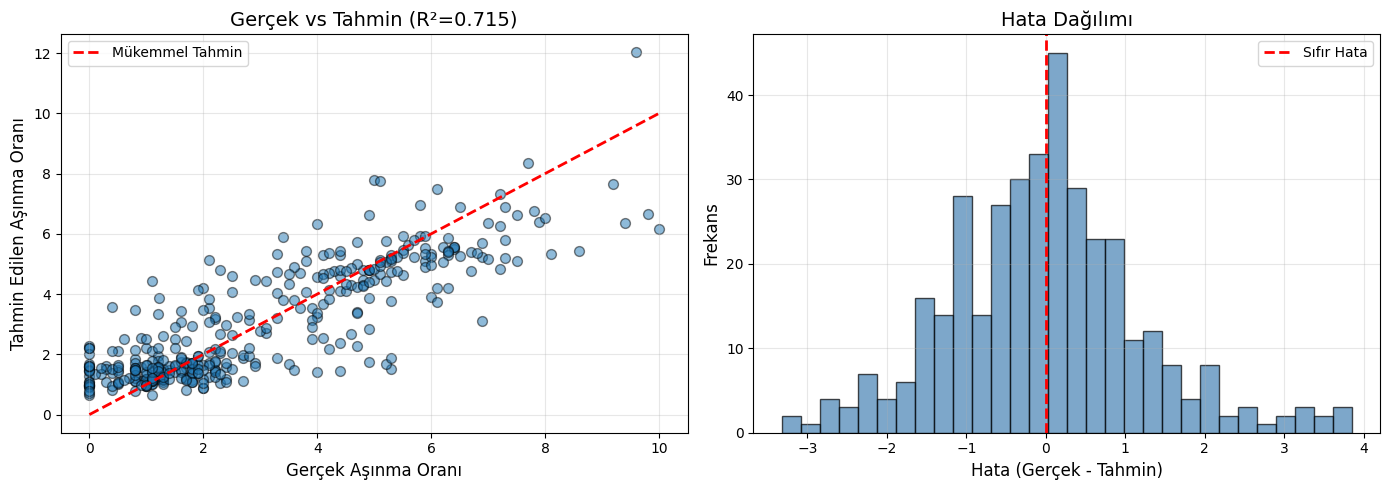


Hata İstatistikleri:
count    368.000000
mean      -0.025664
std        1.217264
min       -3.319103
25%       -0.762305
50%        0.003947
75%        0.633066
max        3.844984
Name: AşınmaOranı, dtype: float64


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sol: Scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.5, edgecolor='k', s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Mükemmel Tahmin')
axes[0].set_xlabel('Gerçek Aşınma Oranı', fontsize=12)
axes[0].set_ylabel('Tahmin Edilen Aşınma Oranı', fontsize=12)
axes[0].set_title(f'Gerçek vs Tahmin (R²={r2:.3f})', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Sağ: Hata dağılımı
residuals = y_test - y_pred
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Sıfır Hata')
axes[1].set_xlabel('Hata (Gerçek - Tahmin)', fontsize=12)
axes[1].set_ylabel('Frekans', fontsize=12)
axes[1].set_title('Hata Dağılımı', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('\nHata İstatistikleri:')
print(residuals.describe())

## 4. Yeni Veri ile Tahmin (Manuel Girdi)

In [9]:
# Örnek yeni veriler (manuel)
new_data = pd.DataFrame({
    'Kesme Gücü': [12.5, 8.0, 15.0],
    'İlerleme Hızı': [120.0, 60.0, 140.0],
    'RPM': [1200, 1100, 1250]
})

print('Yeni Veri:')
display(new_data)

# Tahmin yap
predictions = model.predict(new_data)

# Sonuçları göster
results = new_data.copy()
results['Tahmin Edilen Aşınma Oranı'] = predictions

print('\nTahmin Sonuçları:')
display(results)

for i, pred in enumerate(predictions, 1):
    print(f'Örnek {i}: Aşınma Oranı = {pred:.3f}')

Yeni Veri:


,Kesme Gücü,İlerleme Hızı,RPM
0,12.5,120.0,1200
1,8.0,60.0,1100
2,15.0,140.0,1250



Tahmin Sonuçları:


,Kesme Gücü,İlerleme Hızı,RPM,Tahmin Edilen Aşınma Oranı
0,12.5,120.0,1200,2.054116
1,8.0,60.0,1100,4.953426
2,15.0,140.0,1250,2.184190


Örnek 1: Aşınma Oranı = 2.054
Örnek 2: Aşınma Oranı = 4.953
Örnek 3: Aşınma Oranı = 2.184


## 5. Gerçek Zamanlı Tahmin Fonksiyonu

In [10]:
def predict_wear_rate(kesme_gucu, ilerleme_hizi, rpm):
    """
    Verilen CNC parametreleri için aşınma oranını tahmin eder.
    
    Parametreler:
    - kesme_gucu: Kesme gücü (kW)
    - ilerleme_hizi: İlerleme hızı (mm/min)
    - rpm: Devir/dakika
    
    Döndürür:
    - Tahmin edilen aşınma oranı
    """
    input_data = pd.DataFrame({
        'Kesme Gücü': [kesme_gucu],
        'İlerleme Hızı': [ilerleme_hizi],
        'RPM': [rpm]
    })
    
    prediction = model.predict(input_data)[0]
    return prediction

# Fonksiyonu test et
print('Fonksiyon Testi:')
print('='*50)
test_cases = [
    (10.0, 100.0, 1150),
    (15.0, 130.0, 1200),
    (5.0, 50.0, 1080)
]

for kg, ih, r in test_cases:
    pred = predict_wear_rate(kg, ih, r)
    print(f'Kesme Gücü={kg} kW, İlerleme Hızı={ih} mm/min, RPM={r} → Aşınma Oranı: {pred:.3f}')

Fonksiyon Testi:
Kesme Gücü=10.0 kW, İlerleme Hızı=100.0 mm/min, RPM=1150 → Aşınma Oranı: 5.426
Kesme Gücü=15.0 kW, İlerleme Hızı=130.0 mm/min, RPM=1200 → Aşınma Oranı: 1.143
Kesme Gücü=5.0 kW, İlerleme Hızı=50.0 mm/min, RPM=1080 → Aşınma Oranı: 4.518


## 6. Toplu Tahmin (Batch Prediction)

In [11]:
# Test setinin tamamı üzerinde detaylı analiz
results_df = pd.DataFrame({
    'Gerçek': y_test.values,
    'Tahmin': y_pred,
    'Hata': y_test.values - y_pred,
    'Mutlak Hata': np.abs(y_test.values - y_pred)
})

# En iyi ve en kötü tahminler
print('En İyi 5 Tahmin (En Düşük Mutlak Hata):')
display(results_df.nsmallest(5, 'Mutlak Hata'))

print('\nEn Kötü 5 Tahmin (En Yüksek Mutlak Hata):')
display(results_df.nlargest(5, 'Mutlak Hata'))

# Hata aralıklarına göre dağılım
print('\nHata Aralıklarına Göre Dağılım:')
print('='*50)
bins = [0, 0.5, 1.0, 2.0, np.inf]
labels = ['Çok İyi (<0.5)', 'İyi (0.5-1.0)', 'Orta (1.0-2.0)', 'Zayıf (>2.0)']
results_df['Kategori'] = pd.cut(results_df['Mutlak Hata'], bins=bins, labels=labels)
print(results_df['Kategori'].value_counts())

En İyi 5 Tahmin (En Düşük Mutlak Hata):


,Gerçek,Tahmin,Hata,Mutlak Hata
56,5.3,5.300110,-0.000110,0.000110
71,1.1,1.101021,-0.001021,0.001021
159,1.1,1.101396,-0.001396,0.001396
263,1.7,1.703848,-0.003848,0.003848
35,4.8,4.791996,0.008004,0.008004



En Kötü 5 Tahmin (En Yüksek Mutlak Hata):


,Gerçek,Tahmin,Hata,Mutlak Hata
132,10.0,6.155016,3.844984,3.844984
156,6.9,3.091736,3.808264,3.808264
178,5.3,1.521144,3.778856,3.778856
297,5.2,1.671622,3.528378,3.528378
325,5.3,1.878596,3.421404,3.421404



Hata Aralıklarına Göre Dağılım:
Kategori
Çok İyi (<0.5)    139
İyi (0.5-1.0)      98
Orta (1.0-2.0)     88
Zayıf (>2.0)       43
Name: count, dtype: int64


## 7. Model Özeti ve Öneriler

In [12]:
print('MODEL PERFORMANS ÖZETİ')
print('='*70)
print(f'Model Tipi: {type(model).__name__}')
print(f'Özellikler: {", ".join(feature_cols)}')
print(f'Test Örnekleri: {len(y_test)}')
print()
print('Metrikler:')
print(f'  • Ortalama Mutlak Hata (MAE): {mae:.3f}')
print(f'  • Kök Ortalama Kare Hata (RMSE): {rmse:.3f}')
print(f'  • Belirlilik Katsayısı (R²): {r2:.3f}')
print()
print('Yorum:')
if r2 > 0.7:
    print('  ✅ Model yüksek doğrulukla tahmin yapıyor.')
elif r2 > 0.5:
    print('  ⚠️  Model makul seviyede tahmin yapıyor, iyileştirme mümkün.')
else:
    print('  ❌ Model performansı düşük, yeniden eğitim veya özellik mühendisliği gerekli.')
print()
print('Öneriler:')
print('  1. Yeni veri toplandıkça modeli periyodik olarak yeniden eğitin')
print('  2. Ekstrem değerlerde (outliers) tahmin hatası artabilir')
print('  3. Üretim ortamında model versiyonlarını takip edin')
print('  4. A/B testi ile farklı model versiyonlarını karşılaştırın')

MODEL PERFORMANS ÖZETİ
Model Tipi: GradientBoostingRegressor
Özellikler: Kesme Gücü, İlerleme Hızı, RPM
Test Örnekleri: 368

Metrikler:
  • Ortalama Mutlak Hata (MAE): 0.913
  • Kök Ortalama Kare Hata (RMSE): 1.216
  • Belirlilik Katsayısı (R²): 0.715

Yorum:
  ✅ Model yüksek doğrulukla tahmin yapıyor.

Öneriler:
  1. Yeni veri toplandıkça modeli periyodik olarak yeniden eğitin
  2. Ekstrem değerlerde (outliers) tahmin hatası artabilir
  3. Üretim ortamında model versiyonlarını takip edin
  4. A/B testi ile farklı model versiyonlarını karşılaştırın
